# Segmentation of Brain Tumors

Use FCLeNet for **segmentation** of an image.
Segment brain tumors, from 2D slices of brain MRIs.

## Stochastic Gradient Descent

PyTorch has also very useful functionality for handling datasets and sampling of training data.

In [1]:
from utils.plotting import plot_train_progress, display_image_dynamically
import scipy.misc

def compute_accuracy(lbls_pred, lbls_real):
    # lbls_pred, lbls_read: np.arrays of labels (after argmax), not probabilities/onehot.
    acc = np.mean(lbls_pred == lbls_real) * 100.
    return acc

def get_random_batch(train_imgs, train_lbls, N_batch_size, rng):
    # train_imgs: Images for training. Numpy array of shape [S, H, W]
    # train_lbls: Labels of the training images.
    # N_batch_size: integer. Size that the batch should have.
    indices = rng.randint(low=0, high=train_imgs.shape[0], size=N_batch_size, dtype='int32')
    train_imgs_batch = train_imgs[indices]
    train_lbls_batch = train_lbls[indices]
    return [train_imgs_batch, train_lbls_batch]

def gradient_descent(net, loss_func, grad_descent_optimizer, rng,
                     train_imgs, train_lbls, test_imgs, test_lbls,
                     N_batch_size, total_iters, iters_per_test=-1,
                     is_tumor_segm=False ):
    # net: Instance of a model.
    # loss_func: Function that computes the loss. See functions: cross_entropy.
    # grad_descent_optimizer: From torch.optim
    # rng: numpy random number generator
    # train_imgs: The training images. Numpy array, shape [S_tr, H, W]
    # test_imgs: Save as above, for testing images. [S_te, H, W]
    # train_lbls: One hot representation of labels corresponding to train_imgs. Numpy array, shape [S_tr, C]
    # test_lbls: As above, but for testing data. [S_te, C]
    # N_batch_size: Size N of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many iterations in total to perform.
    # iters_per_test: Integer. Every that many iterations the model predicts the test data and accuracy is reported.
    values_to_plot = {'loss':[], 'acc_train': [], 'acc_test': []}
    
    for t in range(total_iters):
        
        x, y_real = get_random_batch(train_imgs, train_lbls, N_batch_size, rng)
        
        y_pred = net.forward( torch.tensor(x, dtype=torch.float) )
        
        loss = loss_func(y_pred, torch.tensor(y_real, dtype=torch.float)) # Cross Entropy

        loss.backward() # Computes grads with auto-differentiation. Stores them in each params.grads
        
        # Update weights with gradient descent. One of optimizers given by torch.optim
        grad_descent_optimizer.step()
        grad_descent_optimizer.zero_grad()  # zero the parameter gradients.
        
        # ==== Report training loss and accuracy ======
        lbls_pred = np.argmax(y_pred.detach().numpy(), axis=1) # Get labels from the probabilities.
        lbls_real = np.argmax(y_real, axis=1) # Get labels from one-hot
        acc_train = compute_accuracy(lbls_pred, lbls_real)
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss.item()), "\t Accuracy: {0:.2f}".format(acc_train))
        
        # =============== Every few iterations, predict the testing-database ================#
        if t==total_iters-1 or t%iters_per_test == 0:
            y_pred_test = net.forward(torch.tensor(test_imgs, dtype=torch.float))
            y_pred_test_numpy = y_pred_test.detach().numpy()
            # ==== Report test accuracy ======
            lbls_pred_test = np.argmax(y_pred_test_numpy, axis=1)
            lbls_real_test = np.argmax(test_lbls, axis=1)
            acc_test = compute_accuracy(lbls_pred_test, lbls_real_test)
            print("\t\t\t\t\t\t\t\t Testing Accuracy: {0:.2f}".format(acc_test))
            
            # Keep list of metrics to plot progress.
            values_to_plot['loss'].append(loss.item())
            values_to_plot['acc_train'].append(acc_train)
            values_to_plot['acc_test'].append(acc_test)
            
            if is_tumor_segm:
                display_image_dynamically(y_pred_test_numpy[0,1,:,:])
                #scipy.misc.imsave('./pred_prob.png', y_pred_test_numpy[0,1,:,:])
                #scipy.misc.imsave('./pred_segm.png', lbls_pred_test[0,:,:])
                
                
    # In the end of the process, plot loss accuracy on training and testing data.
    plot_train_progress(values_to_plot['loss'], values_to_plot['acc_train'], values_to_plot['acc_test'], iters_per_test)
    



## Load data & make one-hot ground truth labels

[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (2, 169, 129) || Data type:  float64
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (2, 169, 129) || Data type:  uint8
[train] Intensities in images [min,max]: -1.6122578242528567 4.101347108239887
[train] Values in class labels: [0 1]
[test_imgs] Type:  <class 'numpy.ndarray'> || Shape: (1, 169, 129) || Data type:  float64
[test_lbls] Type:  <class 'numpy.ndarray'> || Shape: (1, 169, 129) || Data type:  uint8
[test] Intensities in images [min,max]: -1.3070482203383063 3.7549178309060265
[test] Values in class labels: [0 1]
[train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (2, 169, 129)  || Data type:  uint8
[train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (2, 2, 169, 129)  || Data type:  float64
[test_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (1, 169, 129)  || Data type:  uint8
[test_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (1, 2, 169, 129)  || Data type:  float64
Plotting the 

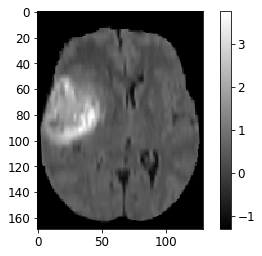

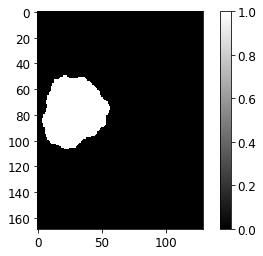

In [2]:
import numpy as np
from utils.data_utils import get_tumor_data
from utils.plotting import plot_image

DATA_DIR_TUMOR = 'path to tumor'

# Load the data. NOTE: Their intensities are already normalized.
train_imgs, train_lbls = get_tumor_data(data_dir=DATA_DIR_TUMOR, train=True)
test_imgs, test_lbls = get_tumor_data(data_dir=DATA_DIR_TUMOR, train=False)

print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('[train] Intensities in images [min,max]:', np.min(train_imgs), np.max(train_imgs))
print('[train] Values in class labels:', np.unique(train_lbls))
print("[test_imgs] Type: ", type(test_imgs), "|| Shape:", test_imgs.shape, "|| Data type: ", test_imgs.dtype )
print("[test_lbls] Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, "|| Data type: ", test_lbls.dtype )
print('[test] Intensities in images [min,max]:', np.min(test_imgs), np.max(test_imgs))
print('[test] Values in class labels:', np.unique(test_lbls))

C_classes = len(np.unique(train_lbls))

# Change representation of labels to one-hot vectors of length C=2.
def make_NHW_lbls_onehot(lbls, num_classes):
    # lbls: np.array [N, H, W], ints
    # returns: np.array [N, H, W, C], 0 or 1
    onehot_shape = (lbls.shape[0], num_classes, lbls.shape[1], lbls.shape[2])
    lbls_onehot = np.zeros(shape=onehot_shape)
    for n in range(lbls.shape[0]):
        for x in range(lbls.shape[1]):
            for y in range(lbls.shape[2]):
                for c in range(num_classes):
                    lbls_onehot[n,c,x,y] = 1 if lbls[n,x,y] == c else 0
    return lbls_onehot

train_lbls_onehot = make_NHW_lbls_onehot(train_lbls, C_classes)
test_lbls_onehot = make_NHW_lbls_onehot(test_lbls, C_classes)
print("[train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("[train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )
print("[test_lbls]        Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, " || Data type: ", test_lbls.dtype )
print("[test_lbls_onehot] Type: ", type(test_lbls_onehot), "|| Shape:", test_lbls_onehot.shape, " || Data type: ", test_lbls_onehot.dtype )

# Plot the test image
print("Plotting the test image and its ground truth segmentation label.")
plot_image(test_imgs[0,:,:])
plot_image(test_lbls[0,:,:])


The output of the above:
- 2 training images, each of shape 169 x 129. (train_imgs.shape = (2, 169, 129))  
- 1 testing image, also of shape 169 x 129. (test_imgs.shape = (1, 169, 129))  

Each has an associated ground truth **segmentation mask**:
- Each segmentation mask is also of shape 169 x 129. Aligned with corresponding image.
- Each segmentation mask is binary. A pixel has value 0 if it is backround, 1 if it is tumor.
- 2 segmentation masks for training (train_lbls.shape=(2,169,129))
- 1 segmentation mask for testing (test_lbls.shape=(2,169,129))
- The one-hot segmentation masks are respectively of shape (2, 2, 169, 129) and (1, 2, 169, 129).

Subsequently, train a **CNN for segmentation**.  
It can be perceived as if **pixel-wise classification**...

## Build FCLeNet with learnt upsampling for segmentation

For segmentation, we need fully-convolutional networks, but with output that is at the same resolution as their input. So that they give us a predicted class posterior probability for each pixel.

In [5]:
from utils.neural_net import torch_repeat
import torch.nn as nn

class FCLeNet_Seg(nn.Module):
    def __init__(self, num_classes):
        super(FCLeNet_Seg, self).__init__()
        # conv(5x5)->pool(2x2)->conv(5x5)->pool(2x2)->conv(5x5)->conv(1x1)->upsample->conv(1x1)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=True, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, bias=True, padding=0)
        self.conv4 = nn.Conv2d(120, 84, kernel_size=1, bias=True, padding=0)
        self.conv_ups = nn.Conv2d(84, 84, kernel_size=4, bias=False, padding=0) # Kernel for the upsampling step.
        self.conv5 = nn.Conv2d(84, num_classes, kernel_size=1, bias=True, padding=0)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch_repeat(x, repeats=4, axis=2)
        x = torch_repeat(x, repeats=4, axis=3)
        x = self.conv_ups(x) 
        x = self.conv5(x)
        # Note: The repeats and conv_ups can be replaced with a single torch.nn.ConvTranspose2d
        
        y_pred = F.softmax(x, dim=1) # y_pred.shape = [N, Classes, H_out, W_out]
        return y_pred
    

## Cross entropy for segmentation

A segmentation network can be seen as if it is trained for pixel-wise classification.  
It can be perceived as if in the loss, each pixel is treated as another sample.  

In [6]:
def cross_entropy_segmentation(y_pred, y_real, eps=1e-7):
    # Cross entropy for segmentation.
    # y_pred: Tensor of shape [N, Classes, H_out, W_out]. Predicted class-posterior probabilities from forward().
    # y_real: One-hot representation of segmentation masks. Same shape as y_pred.
    
    x_entr_per_sample = - torch.sum( y_real * torch.log(y_pred + eps), dim=1) # Sum over classes.
    # x_entr_per_sample is now of shape [N, H_out, W_out]
    loss = torch.mean(x_entr_per_sample, dim=(0,1,2)) # Mean over batch & over spatial positions.
    
    return loss

## Train FCLeNet for segmentation

The network's outputs are 31 pixels less in each spatial dimension (H,W) than the input.  
So, to get a segmentation for the whole input, first pad input with 31 pixels along dimensions (H,W).

train_imgs_cnn.shape= (2, 1, 200, 160)
train_lbls.shape= (2, 169, 129)
[iter: 0 ]: Training Loss: 0.66 	 Accuracy: 95.75
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


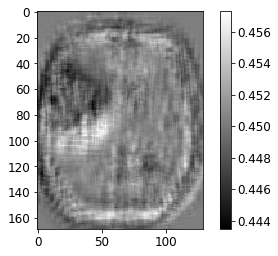

[iter: 1 ]: Training Loss: 0.61 	 Accuracy: 95.75
[iter: 2 ]: Training Loss: 0.57 	 Accuracy: 92.81
[iter: 3 ]: Training Loss: 0.54 	 Accuracy: 92.81
[iter: 4 ]: Training Loss: 0.51 	 Accuracy: 92.81
[iter: 5 ]: Training Loss: 0.50 	 Accuracy: 89.87
[iter: 6 ]: Training Loss: 0.43 	 Accuracy: 95.75
[iter: 7 ]: Training Loss: 0.43 	 Accuracy: 92.81
[iter: 8 ]: Training Loss: 0.36 	 Accuracy: 95.75
[iter: 9 ]: Training Loss: 0.33 	 Accuracy: 95.75
[iter: 10 ]: Training Loss: 0.35 	 Accuracy: 92.81
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


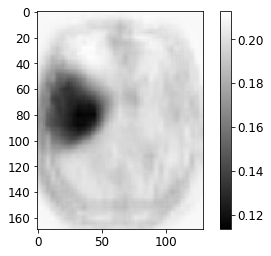

[iter: 11 ]: Training Loss: 0.28 	 Accuracy: 95.75
[iter: 12 ]: Training Loss: 0.26 	 Accuracy: 95.75
[iter: 13 ]: Training Loss: 0.31 	 Accuracy: 92.81
[iter: 14 ]: Training Loss: 0.23 	 Accuracy: 95.75
[iter: 15 ]: Training Loss: 0.21 	 Accuracy: 95.75
[iter: 16 ]: Training Loss: 0.20 	 Accuracy: 95.75
[iter: 17 ]: Training Loss: 0.27 	 Accuracy: 92.81
[iter: 18 ]: Training Loss: 0.19 	 Accuracy: 95.75
[iter: 19 ]: Training Loss: 0.25 	 Accuracy: 92.81
[iter: 20 ]: Training Loss: 0.17 	 Accuracy: 95.75
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


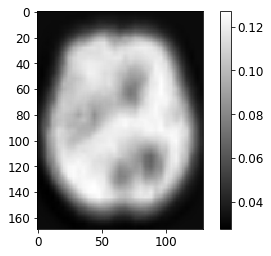

[iter: 21 ]: Training Loss: 0.23 	 Accuracy: 92.81
[iter: 22 ]: Training Loss: 0.22 	 Accuracy: 92.81
[iter: 23 ]: Training Loss: 0.22 	 Accuracy: 92.81
[iter: 24 ]: Training Loss: 0.21 	 Accuracy: 92.81
[iter: 25 ]: Training Loss: 0.15 	 Accuracy: 95.75
[iter: 26 ]: Training Loss: 0.21 	 Accuracy: 92.81
[iter: 27 ]: Training Loss: 0.20 	 Accuracy: 92.81
[iter: 28 ]: Training Loss: 0.20 	 Accuracy: 92.81
[iter: 29 ]: Training Loss: 0.25 	 Accuracy: 89.87
[iter: 30 ]: Training Loss: 0.24 	 Accuracy: 89.87
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


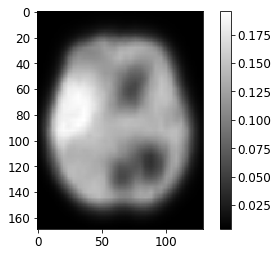

[iter: 31 ]: Training Loss: 0.19 	 Accuracy: 92.81
[iter: 32 ]: Training Loss: 0.18 	 Accuracy: 92.81
[iter: 33 ]: Training Loss: 0.13 	 Accuracy: 95.75
[iter: 34 ]: Training Loss: 0.18 	 Accuracy: 92.81
[iter: 35 ]: Training Loss: 0.22 	 Accuracy: 89.87
[iter: 36 ]: Training Loss: 0.17 	 Accuracy: 92.81
[iter: 37 ]: Training Loss: 0.17 	 Accuracy: 92.81
[iter: 38 ]: Training Loss: 0.21 	 Accuracy: 89.87
[iter: 39 ]: Training Loss: 0.16 	 Accuracy: 92.81
[iter: 40 ]: Training Loss: 0.11 	 Accuracy: 95.75
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


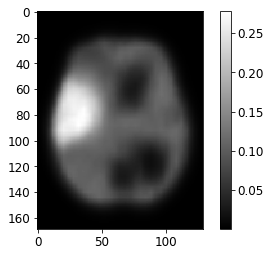

[iter: 41 ]: Training Loss: 0.11 	 Accuracy: 95.75
[iter: 42 ]: Training Loss: 0.15 	 Accuracy: 92.81
[iter: 43 ]: Training Loss: 0.14 	 Accuracy: 92.81
[iter: 44 ]: Training Loss: 0.18 	 Accuracy: 89.87
[iter: 45 ]: Training Loss: 0.11 	 Accuracy: 95.75
[iter: 46 ]: Training Loss: 0.14 	 Accuracy: 92.81
[iter: 47 ]: Training Loss: 0.13 	 Accuracy: 92.81
[iter: 48 ]: Training Loss: 0.12 	 Accuracy: 92.81
[iter: 49 ]: Training Loss: 0.12 	 Accuracy: 92.81
[iter: 50 ]: Training Loss: 0.15 	 Accuracy: 89.87
								 Testing Accuracy: 90.18
Plotting image of shape:  (169, 129)


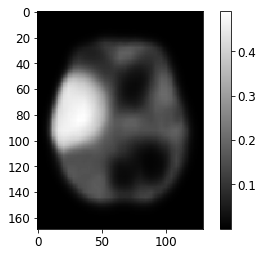

[iter: 51 ]: Training Loss: 0.12 	 Accuracy: 92.81
[iter: 52 ]: Training Loss: 0.11 	 Accuracy: 92.81
[iter: 53 ]: Training Loss: 0.11 	 Accuracy: 93.24
[iter: 54 ]: Training Loss: 0.10 	 Accuracy: 93.67
[iter: 55 ]: Training Loss: 0.10 	 Accuracy: 95.23
[iter: 56 ]: Training Loss: 0.09 	 Accuracy: 95.37
[iter: 57 ]: Training Loss: 0.09 	 Accuracy: 96.78
[iter: 58 ]: Training Loss: 0.09 	 Accuracy: 96.26
[iter: 59 ]: Training Loss: 0.09 	 Accuracy: 97.68
[iter: 60 ]: Training Loss: 0.11 	 Accuracy: 95.17
								 Testing Accuracy: 97.72
Plotting image of shape:  (169, 129)


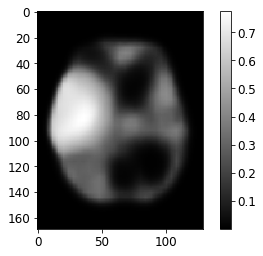

[iter: 61 ]: Training Loss: 0.13 	 Accuracy: 97.78
[iter: 62 ]: Training Loss: 0.06 	 Accuracy: 97.43
[iter: 63 ]: Training Loss: 0.09 	 Accuracy: 96.92
[iter: 64 ]: Training Loss: 0.08 	 Accuracy: 98.30
[iter: 65 ]: Training Loss: 0.05 	 Accuracy: 97.84
[iter: 66 ]: Training Loss: 0.07 	 Accuracy: 98.33
[iter: 67 ]: Training Loss: 0.07 	 Accuracy: 97.72
[iter: 68 ]: Training Loss: 0.07 	 Accuracy: 98.31
[iter: 69 ]: Training Loss: 0.07 	 Accuracy: 97.12
[iter: 70 ]: Training Loss: 0.10 	 Accuracy: 96.95
								 Testing Accuracy: 92.88
Plotting image of shape:  (169, 129)


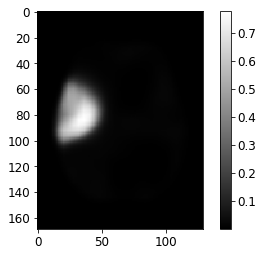

[iter: 71 ]: Training Loss: 0.07 	 Accuracy: 96.18
[iter: 72 ]: Training Loss: 0.12 	 Accuracy: 95.48
[iter: 73 ]: Training Loss: 0.07 	 Accuracy: 97.53
[iter: 74 ]: Training Loss: 0.05 	 Accuracy: 98.93
[iter: 75 ]: Training Loss: 0.05 	 Accuracy: 97.46
[iter: 76 ]: Training Loss: 0.07 	 Accuracy: 97.68
[iter: 77 ]: Training Loss: 0.07 	 Accuracy: 97.73
[iter: 78 ]: Training Loss: 0.06 	 Accuracy: 98.19
[iter: 79 ]: Training Loss: 0.08 	 Accuracy: 96.90
[iter: 80 ]: Training Loss: 0.12 	 Accuracy: 94.60
								 Testing Accuracy: 93.96
Plotting image of shape:  (169, 129)


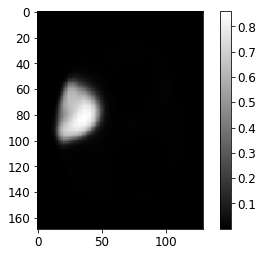

[iter: 81 ]: Training Loss: 0.11 	 Accuracy: 95.58
[iter: 82 ]: Training Loss: 0.24 	 Accuracy: 83.28
[iter: 83 ]: Training Loss: 0.14 	 Accuracy: 94.34
[iter: 84 ]: Training Loss: 0.08 	 Accuracy: 98.18
[iter: 85 ]: Training Loss: 0.09 	 Accuracy: 97.15
[iter: 86 ]: Training Loss: 0.07 	 Accuracy: 98.17
[iter: 87 ]: Training Loss: 0.06 	 Accuracy: 98.16
[iter: 88 ]: Training Loss: 0.05 	 Accuracy: 98.35
[iter: 89 ]: Training Loss: 0.06 	 Accuracy: 97.68
[iter: 90 ]: Training Loss: 0.06 	 Accuracy: 98.49
								 Testing Accuracy: 93.74
Plotting image of shape:  (169, 129)


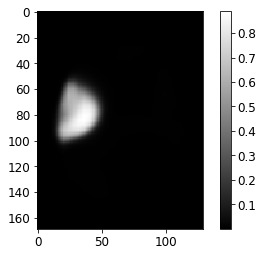

[iter: 91 ]: Training Loss: 0.16 	 Accuracy: 94.05
[iter: 92 ]: Training Loss: 0.27 	 Accuracy: 81.99
[iter: 93 ]: Training Loss: 0.10 	 Accuracy: 98.28
[iter: 94 ]: Training Loss: 0.08 	 Accuracy: 98.99
[iter: 95 ]: Training Loss: 0.09 	 Accuracy: 96.71
[iter: 96 ]: Training Loss: 0.07 	 Accuracy: 98.96
[iter: 97 ]: Training Loss: 0.09 	 Accuracy: 97.07
[iter: 98 ]: Training Loss: 0.06 	 Accuracy: 99.01
[iter: 99 ]: Training Loss: 0.08 	 Accuracy: 97.31
[iter: 100 ]: Training Loss: 0.08 	 Accuracy: 97.27
								 Testing Accuracy: 97.48
Plotting image of shape:  (169, 129)


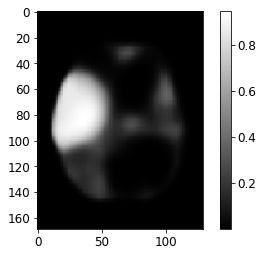

[iter: 101 ]: Training Loss: 0.07 	 Accuracy: 98.10
[iter: 102 ]: Training Loss: 0.08 	 Accuracy: 97.42
[iter: 103 ]: Training Loss: 0.08 	 Accuracy: 98.45
[iter: 104 ]: Training Loss: 0.13 	 Accuracy: 95.09
[iter: 105 ]: Training Loss: 0.07 	 Accuracy: 97.23
[iter: 106 ]: Training Loss: 0.08 	 Accuracy: 97.21
[iter: 107 ]: Training Loss: 0.05 	 Accuracy: 98.31
[iter: 108 ]: Training Loss: 0.05 	 Accuracy: 98.39
[iter: 109 ]: Training Loss: 0.04 	 Accuracy: 99.05
[iter: 110 ]: Training Loss: 0.08 	 Accuracy: 97.17
								 Testing Accuracy: 97.75
Plotting image of shape:  (169, 129)


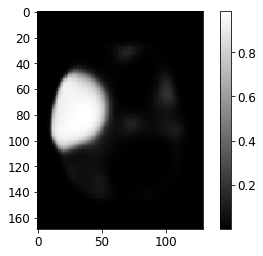

[iter: 111 ]: Training Loss: 0.06 	 Accuracy: 98.16
[iter: 112 ]: Training Loss: 0.04 	 Accuracy: 98.44
[iter: 113 ]: Training Loss: 0.04 	 Accuracy: 98.49
[iter: 114 ]: Training Loss: 0.04 	 Accuracy: 98.52
[iter: 115 ]: Training Loss: 0.04 	 Accuracy: 98.53
[iter: 116 ]: Training Loss: 0.04 	 Accuracy: 98.53
[iter: 117 ]: Training Loss: 0.05 	 Accuracy: 98.08
[iter: 118 ]: Training Loss: 0.05 	 Accuracy: 98.45
[iter: 119 ]: Training Loss: 0.11 	 Accuracy: 95.98
[iter: 120 ]: Training Loss: 0.25 	 Accuracy: 85.09
								 Testing Accuracy: 95.83
Plotting image of shape:  (169, 129)


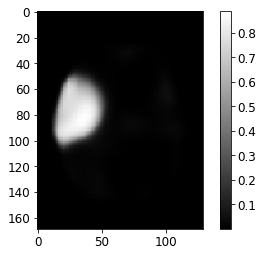

[iter: 121 ]: Training Loss: 0.07 	 Accuracy: 97.63
[iter: 122 ]: Training Loss: 0.07 	 Accuracy: 97.70
[iter: 123 ]: Training Loss: 0.05 	 Accuracy: 98.01
[iter: 124 ]: Training Loss: 0.06 	 Accuracy: 98.32
[iter: 125 ]: Training Loss: 0.06 	 Accuracy: 97.89
[iter: 126 ]: Training Loss: 0.05 	 Accuracy: 98.40
[iter: 127 ]: Training Loss: 0.04 	 Accuracy: 98.58
[iter: 128 ]: Training Loss: 0.04 	 Accuracy: 98.60
[iter: 129 ]: Training Loss: 0.04 	 Accuracy: 98.60
[iter: 130 ]: Training Loss: 0.04 	 Accuracy: 98.18
								 Testing Accuracy: 97.95
Plotting image of shape:  (169, 129)


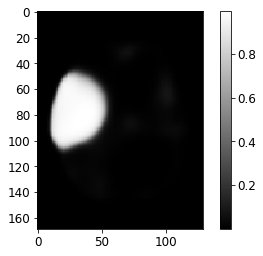

[iter: 131 ]: Training Loss: 0.04 	 Accuracy: 98.45
[iter: 132 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 133 ]: Training Loss: 0.06 	 Accuracy: 97.83
[iter: 134 ]: Training Loss: 0.07 	 Accuracy: 97.98
[iter: 135 ]: Training Loss: 0.12 	 Accuracy: 95.67
[iter: 136 ]: Training Loss: 0.21 	 Accuracy: 87.06
[iter: 137 ]: Training Loss: 0.06 	 Accuracy: 98.06
[iter: 138 ]: Training Loss: 0.05 	 Accuracy: 99.10
[iter: 139 ]: Training Loss: 0.04 	 Accuracy: 99.00
[iter: 140 ]: Training Loss: 0.06 	 Accuracy: 98.03
								 Testing Accuracy: 97.26
Plotting image of shape:  (169, 129)


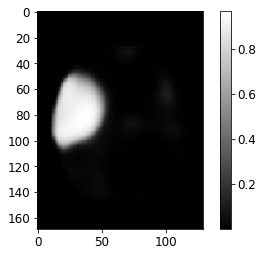

[iter: 141 ]: Training Loss: 0.06 	 Accuracy: 97.95
[iter: 142 ]: Training Loss: 0.05 	 Accuracy: 98.43
[iter: 143 ]: Training Loss: 0.04 	 Accuracy: 98.56
[iter: 144 ]: Training Loss: 0.04 	 Accuracy: 98.58
[iter: 145 ]: Training Loss: 0.05 	 Accuracy: 98.15
[iter: 146 ]: Training Loss: 0.04 	 Accuracy: 98.65
[iter: 147 ]: Training Loss: 0.05 	 Accuracy: 98.24
[iter: 148 ]: Training Loss: 0.04 	 Accuracy: 98.61
[iter: 149 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 150 ]: Training Loss: 0.03 	 Accuracy: 99.04
								 Testing Accuracy: 97.05
Plotting image of shape:  (169, 129)


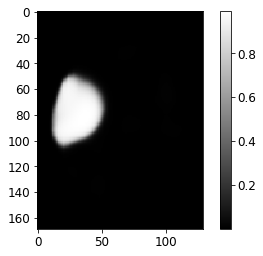

[iter: 151 ]: Training Loss: 0.04 	 Accuracy: 98.55
[iter: 152 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 153 ]: Training Loss: 0.04 	 Accuracy: 98.33
[iter: 154 ]: Training Loss: 0.04 	 Accuracy: 98.46
[iter: 155 ]: Training Loss: 0.03 	 Accuracy: 98.62
[iter: 156 ]: Training Loss: 0.04 	 Accuracy: 98.36
[iter: 157 ]: Training Loss: 0.03 	 Accuracy: 98.52
[iter: 158 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 159 ]: Training Loss: 0.02 	 Accuracy: 99.09
[iter: 160 ]: Training Loss: 0.04 	 Accuracy: 98.58
								 Testing Accuracy: 98.04
Plotting image of shape:  (169, 129)


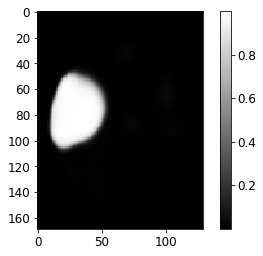

[iter: 161 ]: Training Loss: 0.03 	 Accuracy: 98.79
[iter: 162 ]: Training Loss: 0.06 	 Accuracy: 97.79
[iter: 163 ]: Training Loss: 0.04 	 Accuracy: 98.10
[iter: 164 ]: Training Loss: 0.03 	 Accuracy: 98.76
[iter: 165 ]: Training Loss: 0.04 	 Accuracy: 98.49
[iter: 166 ]: Training Loss: 0.03 	 Accuracy: 98.73
[iter: 167 ]: Training Loss: 0.04 	 Accuracy: 98.48
[iter: 168 ]: Training Loss: 0.04 	 Accuracy: 98.63
[iter: 169 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 170 ]: Training Loss: 0.02 	 Accuracy: 99.12
								 Testing Accuracy: 97.24
Plotting image of shape:  (169, 129)


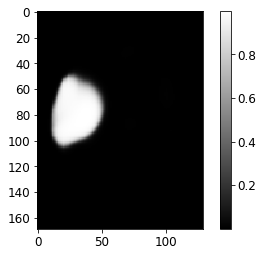

[iter: 171 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 172 ]: Training Loss: 0.03 	 Accuracy: 98.61
[iter: 173 ]: Training Loss: 0.03 	 Accuracy: 98.74
[iter: 174 ]: Training Loss: 0.02 	 Accuracy: 99.15
[iter: 175 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 176 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 177 ]: Training Loss: 0.03 	 Accuracy: 98.76
[iter: 178 ]: Training Loss: 0.02 	 Accuracy: 99.09
[iter: 179 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 180 ]: Training Loss: 0.03 	 Accuracy: 98.88
								 Testing Accuracy: 97.00
Plotting image of shape:  (169, 129)


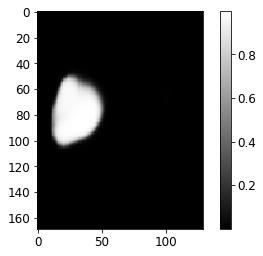

[iter: 181 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 182 ]: Training Loss: 0.04 	 Accuracy: 98.35
[iter: 183 ]: Training Loss: 0.04 	 Accuracy: 98.50
[iter: 184 ]: Training Loss: 0.03 	 Accuracy: 98.77
[iter: 185 ]: Training Loss: 0.03 	 Accuracy: 98.61
[iter: 186 ]: Training Loss: 0.03 	 Accuracy: 98.75
[iter: 187 ]: Training Loss: 0.04 	 Accuracy: 98.55
[iter: 188 ]: Training Loss: 0.04 	 Accuracy: 98.56
[iter: 189 ]: Training Loss: 0.04 	 Accuracy: 98.25
[iter: 190 ]: Training Loss: 0.05 	 Accuracy: 98.35
								 Testing Accuracy: 96.14
Plotting image of shape:  (169, 129)


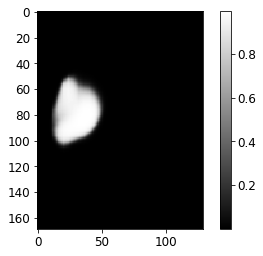

[iter: 191 ]: Training Loss: 0.05 	 Accuracy: 98.01
[iter: 192 ]: Training Loss: 0.04 	 Accuracy: 98.45
[iter: 193 ]: Training Loss: 0.03 	 Accuracy: 98.78
[iter: 194 ]: Training Loss: 0.03 	 Accuracy: 98.84
[iter: 195 ]: Training Loss: 0.03 	 Accuracy: 98.85
[iter: 196 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 197 ]: Training Loss: 0.03 	 Accuracy: 98.76
[iter: 198 ]: Training Loss: 0.03 	 Accuracy: 98.61
[iter: 199 ]: Training Loss: 0.04 	 Accuracy: 98.68
[iter: 200 ]: Training Loss: 0.04 	 Accuracy: 98.55
								 Testing Accuracy: 98.16
Plotting image of shape:  (169, 129)


/anaconda3/envs/mli/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


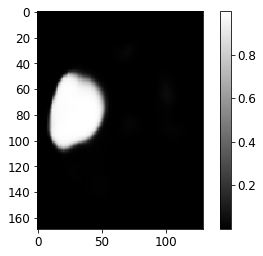

[iter: 201 ]: Training Loss: 0.03 	 Accuracy: 98.78
[iter: 202 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 203 ]: Training Loss: 0.03 	 Accuracy: 98.81
[iter: 204 ]: Training Loss: 0.03 	 Accuracy: 98.72
[iter: 205 ]: Training Loss: 0.03 	 Accuracy: 98.80
[iter: 206 ]: Training Loss: 0.03 	 Accuracy: 98.90
[iter: 207 ]: Training Loss: 0.03 	 Accuracy: 98.91
[iter: 208 ]: Training Loss: 0.02 	 Accuracy: 99.09
[iter: 209 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 210 ]: Training Loss: 0.02 	 Accuracy: 99.21
								 Testing Accuracy: 97.31
Plotting image of shape:  (169, 129)


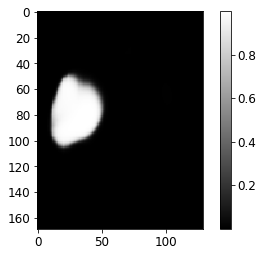

[iter: 211 ]: Training Loss: 0.02 	 Accuracy: 99.18
[iter: 212 ]: Training Loss: 0.03 	 Accuracy: 98.78
[iter: 213 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 214 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 215 ]: Training Loss: 0.03 	 Accuracy: 98.82
[iter: 216 ]: Training Loss: 0.03 	 Accuracy: 98.90
[iter: 217 ]: Training Loss: 0.03 	 Accuracy: 98.91
[iter: 218 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 219 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 220 ]: Training Loss: 0.02 	 Accuracy: 99.11
								 Testing Accuracy: 97.15
Plotting image of shape:  (169, 129)


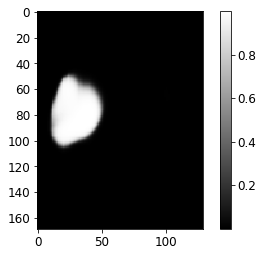

[iter: 221 ]: Training Loss: 0.03 	 Accuracy: 98.72
[iter: 222 ]: Training Loss: 0.03 	 Accuracy: 98.79
[iter: 223 ]: Training Loss: 0.04 	 Accuracy: 98.61
[iter: 224 ]: Training Loss: 0.03 	 Accuracy: 98.79
[iter: 225 ]: Training Loss: 0.03 	 Accuracy: 98.89
[iter: 226 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 227 ]: Training Loss: 0.02 	 Accuracy: 98.96
[iter: 228 ]: Training Loss: 0.02 	 Accuracy: 98.95
[iter: 229 ]: Training Loss: 0.02 	 Accuracy: 98.96
[iter: 230 ]: Training Loss: 0.03 	 Accuracy: 98.81
								 Testing Accuracy: 98.30
Plotting image of shape:  (169, 129)


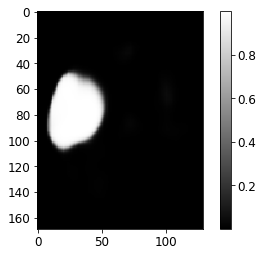

[iter: 231 ]: Training Loss: 0.03 	 Accuracy: 98.83
[iter: 232 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 233 ]: Training Loss: 0.03 	 Accuracy: 98.67
[iter: 234 ]: Training Loss: 0.03 	 Accuracy: 98.55
[iter: 235 ]: Training Loss: 0.05 	 Accuracy: 98.43
[iter: 236 ]: Training Loss: 0.08 	 Accuracy: 97.16
[iter: 237 ]: Training Loss: 0.15 	 Accuracy: 92.56
[iter: 238 ]: Training Loss: 0.13 	 Accuracy: 95.61
[iter: 239 ]: Training Loss: 0.04 	 Accuracy: 98.36
[iter: 240 ]: Training Loss: 0.05 	 Accuracy: 98.38
								 Testing Accuracy: 97.22
Plotting image of shape:  (169, 129)


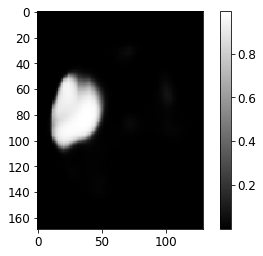

[iter: 241 ]: Training Loss: 0.04 	 Accuracy: 98.36
[iter: 242 ]: Training Loss: 0.03 	 Accuracy: 98.85
[iter: 243 ]: Training Loss: 0.04 	 Accuracy: 98.80
[iter: 244 ]: Training Loss: 0.03 	 Accuracy: 98.85
[iter: 245 ]: Training Loss: 0.03 	 Accuracy: 98.92
[iter: 246 ]: Training Loss: 0.03 	 Accuracy: 98.72
[iter: 247 ]: Training Loss: 0.03 	 Accuracy: 98.80
[iter: 248 ]: Training Loss: 0.04 	 Accuracy: 98.25
[iter: 249 ]: Training Loss: 0.03 	 Accuracy: 98.79
[iter: 250 ]: Training Loss: 0.04 	 Accuracy: 98.34
								 Testing Accuracy: 98.18
Plotting image of shape:  (169, 129)


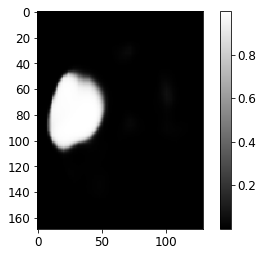

[iter: 251 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 252 ]: Training Loss: 0.03 	 Accuracy: 98.83
[iter: 253 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 254 ]: Training Loss: 0.04 	 Accuracy: 98.46
[iter: 255 ]: Training Loss: 0.03 	 Accuracy: 98.85
[iter: 256 ]: Training Loss: 0.02 	 Accuracy: 98.95
[iter: 257 ]: Training Loss: 0.03 	 Accuracy: 98.86
[iter: 258 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 259 ]: Training Loss: 0.02 	 Accuracy: 98.97
[iter: 260 ]: Training Loss: 0.02 	 Accuracy: 99.00
								 Testing Accuracy: 97.88
Plotting image of shape:  (169, 129)


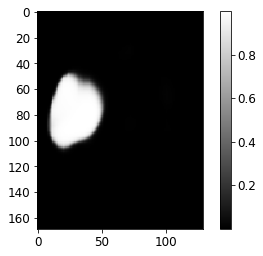

[iter: 261 ]: Training Loss: 0.02 	 Accuracy: 98.99
[iter: 262 ]: Training Loss: 0.02 	 Accuracy: 98.99
[iter: 263 ]: Training Loss: 0.03 	 Accuracy: 98.89
[iter: 264 ]: Training Loss: 0.02 	 Accuracy: 99.02
[iter: 265 ]: Training Loss: 0.02 	 Accuracy: 99.05
[iter: 266 ]: Training Loss: 0.03 	 Accuracy: 98.97
[iter: 267 ]: Training Loss: 0.02 	 Accuracy: 98.99
[iter: 268 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 269 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 270 ]: Training Loss: 0.02 	 Accuracy: 99.01
								 Testing Accuracy: 97.91
Plotting image of shape:  (169, 129)


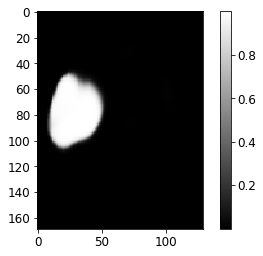

[iter: 271 ]: Training Loss: 0.02 	 Accuracy: 99.02
[iter: 272 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 273 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 274 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 275 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 276 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 277 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 278 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 279 ]: Training Loss: 0.02 	 Accuracy: 99.02
[iter: 280 ]: Training Loss: 0.02 	 Accuracy: 99.02
								 Testing Accuracy: 97.95
Plotting image of shape:  (169, 129)


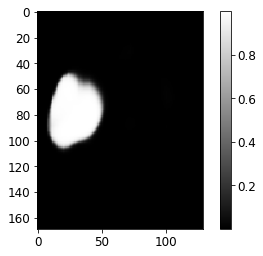

[iter: 281 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 282 ]: Training Loss: 0.02 	 Accuracy: 99.03
[iter: 283 ]: Training Loss: 0.02 	 Accuracy: 99.05
[iter: 284 ]: Training Loss: 0.02 	 Accuracy: 99.03
[iter: 285 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 286 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 287 ]: Training Loss: 0.02 	 Accuracy: 99.05
[iter: 288 ]: Training Loss: 0.02 	 Accuracy: 98.97
[iter: 289 ]: Training Loss: 0.03 	 Accuracy: 98.91
[iter: 290 ]: Training Loss: 0.03 	 Accuracy: 98.84
								 Testing Accuracy: 98.45
Plotting image of shape:  (169, 129)


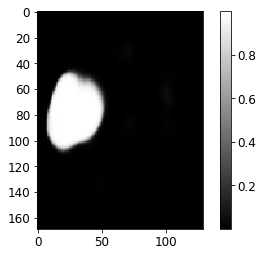

[iter: 291 ]: Training Loss: 0.03 	 Accuracy: 98.82
[iter: 292 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 293 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 294 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 295 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 296 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 297 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 298 ]: Training Loss: 0.02 	 Accuracy: 99.05
[iter: 299 ]: Training Loss: 0.02 	 Accuracy: 99.09
[iter: 300 ]: Training Loss: 0.03 	 Accuracy: 98.82
								 Testing Accuracy: 98.39
Plotting image of shape:  (169, 129)


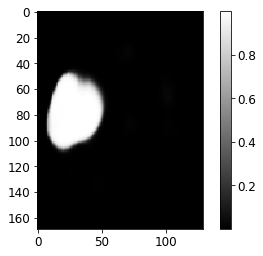

[iter: 301 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 302 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 303 ]: Training Loss: 0.03 	 Accuracy: 98.92
[iter: 304 ]: Training Loss: 0.03 	 Accuracy: 98.77
[iter: 305 ]: Training Loss: 0.03 	 Accuracy: 98.64
[iter: 306 ]: Training Loss: 0.03 	 Accuracy: 98.87
[iter: 307 ]: Training Loss: 0.03 	 Accuracy: 98.85
[iter: 308 ]: Training Loss: 0.02 	 Accuracy: 99.05
[iter: 309 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 310 ]: Training Loss: 0.02 	 Accuracy: 99.17
								 Testing Accuracy: 97.30
Plotting image of shape:  (169, 129)


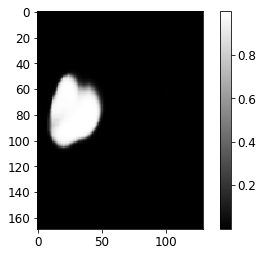

[iter: 311 ]: Training Loss: 0.03 	 Accuracy: 98.90
[iter: 312 ]: Training Loss: 0.02 	 Accuracy: 98.98
[iter: 313 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 314 ]: Training Loss: 0.02 	 Accuracy: 99.00
[iter: 315 ]: Training Loss: 0.02 	 Accuracy: 99.07
[iter: 316 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 317 ]: Training Loss: 0.03 	 Accuracy: 98.75
[iter: 318 ]: Training Loss: 0.04 	 Accuracy: 98.69
[iter: 319 ]: Training Loss: 0.03 	 Accuracy: 98.62
[iter: 320 ]: Training Loss: 0.02 	 Accuracy: 99.07
								 Testing Accuracy: 98.25
Plotting image of shape:  (169, 129)


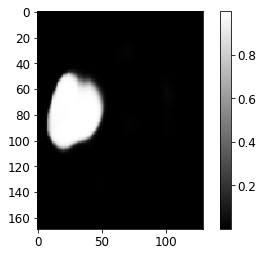

[iter: 321 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 322 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 323 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 324 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 325 ]: Training Loss: 0.02 	 Accuracy: 99.10
[iter: 326 ]: Training Loss: 0.03 	 Accuracy: 98.95
[iter: 327 ]: Training Loss: 0.04 	 Accuracy: 98.43
[iter: 328 ]: Training Loss: 0.04 	 Accuracy: 98.72
[iter: 329 ]: Training Loss: 0.02 	 Accuracy: 99.00
[iter: 330 ]: Training Loss: 0.02 	 Accuracy: 99.10
								 Testing Accuracy: 97.28
Plotting image of shape:  (169, 129)


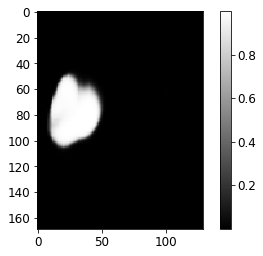

[iter: 331 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 332 ]: Training Loss: 0.02 	 Accuracy: 99.08
[iter: 333 ]: Training Loss: 0.02 	 Accuracy: 99.18
[iter: 334 ]: Training Loss: 0.03 	 Accuracy: 98.95
[iter: 335 ]: Training Loss: 0.02 	 Accuracy: 99.08
[iter: 336 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 337 ]: Training Loss: 0.03 	 Accuracy: 98.96
[iter: 338 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 339 ]: Training Loss: 0.02 	 Accuracy: 99.26
[iter: 340 ]: Training Loss: 0.02 	 Accuracy: 99.00
								 Testing Accuracy: 98.09
Plotting image of shape:  (169, 129)


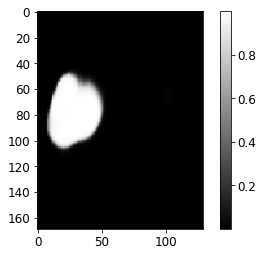

[iter: 341 ]: Training Loss: 0.02 	 Accuracy: 99.09
[iter: 342 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 343 ]: Training Loss: 0.02 	 Accuracy: 99.19
[iter: 344 ]: Training Loss: 0.02 	 Accuracy: 98.98
[iter: 345 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 346 ]: Training Loss: 0.02 	 Accuracy: 99.25
[iter: 347 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 348 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 349 ]: Training Loss: 0.02 	 Accuracy: 99.10
[iter: 350 ]: Training Loss: 0.02 	 Accuracy: 99.11
								 Testing Accuracy: 97.93
Plotting image of shape:  (169, 129)


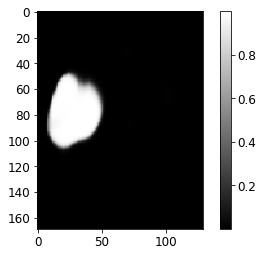

[iter: 351 ]: Training Loss: 0.02 	 Accuracy: 99.19
[iter: 352 ]: Training Loss: 0.02 	 Accuracy: 98.96
[iter: 353 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 354 ]: Training Loss: 0.02 	 Accuracy: 99.08
[iter: 355 ]: Training Loss: 0.02 	 Accuracy: 98.97
[iter: 356 ]: Training Loss: 0.03 	 Accuracy: 98.89
[iter: 357 ]: Training Loss: 0.03 	 Accuracy: 98.81
[iter: 358 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 359 ]: Training Loss: 0.03 	 Accuracy: 98.87
[iter: 360 ]: Training Loss: 0.02 	 Accuracy: 99.08
								 Testing Accuracy: 97.87
Plotting image of shape:  (169, 129)


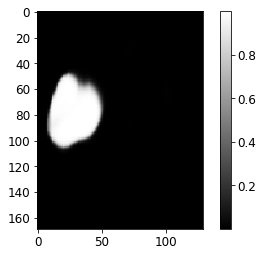

[iter: 361 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 362 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 363 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 364 ]: Training Loss: 0.02 	 Accuracy: 98.97
[iter: 365 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 366 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 367 ]: Training Loss: 0.02 	 Accuracy: 99.18
[iter: 368 ]: Training Loss: 0.02 	 Accuracy: 98.98
[iter: 369 ]: Training Loss: 0.02 	 Accuracy: 99.19
[iter: 370 ]: Training Loss: 0.03 	 Accuracy: 98.98
								 Testing Accuracy: 97.24
Plotting image of shape:  (169, 129)


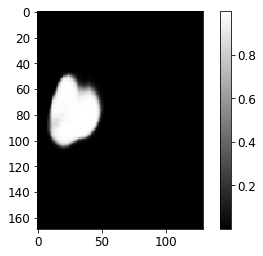

[iter: 371 ]: Training Loss: 0.03 	 Accuracy: 98.92
[iter: 372 ]: Training Loss: 0.02 	 Accuracy: 99.10
[iter: 373 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 374 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 375 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 376 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 377 ]: Training Loss: 0.02 	 Accuracy: 98.98
[iter: 378 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 379 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 380 ]: Training Loss: 0.02 	 Accuracy: 99.19
								 Testing Accuracy: 97.36
Plotting image of shape:  (169, 129)


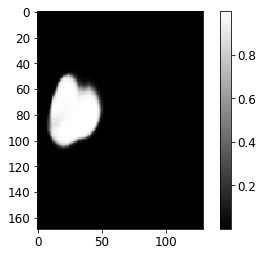

[iter: 381 ]: Training Loss: 0.02 	 Accuracy: 98.98
[iter: 382 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 383 ]: Training Loss: 0.03 	 Accuracy: 98.65
[iter: 384 ]: Training Loss: 0.02 	 Accuracy: 98.97
[iter: 385 ]: Training Loss: 0.02 	 Accuracy: 99.05
[iter: 386 ]: Training Loss: 0.02 	 Accuracy: 98.95
[iter: 387 ]: Training Loss: 0.02 	 Accuracy: 99.14
[iter: 388 ]: Training Loss: 0.02 	 Accuracy: 99.23
[iter: 389 ]: Training Loss: 0.02 	 Accuracy: 99.27
[iter: 390 ]: Training Loss: 0.02 	 Accuracy: 99.28
								 Testing Accuracy: 97.46
Plotting image of shape:  (169, 129)


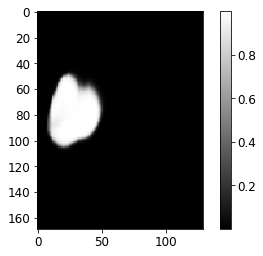

[iter: 391 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 392 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 393 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 394 ]: Training Loss: 0.02 	 Accuracy: 99.27
[iter: 395 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 396 ]: Training Loss: 0.03 	 Accuracy: 98.83
[iter: 397 ]: Training Loss: 0.02 	 Accuracy: 99.07
[iter: 398 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 399 ]: Training Loss: 0.02 	 Accuracy: 99.00
[iter: 400 ]: Training Loss: 0.03 	 Accuracy: 98.93
								 Testing Accuracy: 98.21
Plotting image of shape:  (169, 129)


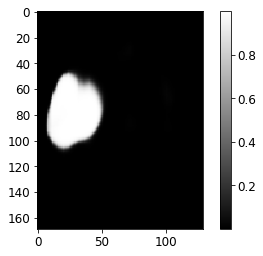

[iter: 401 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 402 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 403 ]: Training Loss: 0.02 	 Accuracy: 99.02
[iter: 404 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 405 ]: Training Loss: 0.02 	 Accuracy: 99.15
[iter: 406 ]: Training Loss: 0.02 	 Accuracy: 99.14
[iter: 407 ]: Training Loss: 0.02 	 Accuracy: 99.07
[iter: 408 ]: Training Loss: 0.02 	 Accuracy: 99.09
[iter: 409 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 410 ]: Training Loss: 0.02 	 Accuracy: 99.04
								 Testing Accuracy: 98.17
Plotting image of shape:  (169, 129)


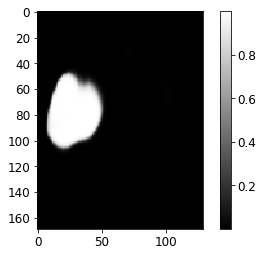

[iter: 411 ]: Training Loss: 0.02 	 Accuracy: 99.10
[iter: 412 ]: Training Loss: 0.02 	 Accuracy: 98.98
[iter: 413 ]: Training Loss: 0.02 	 Accuracy: 99.15
[iter: 414 ]: Training Loss: 0.02 	 Accuracy: 99.14
[iter: 415 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 416 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 417 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 418 ]: Training Loss: 0.02 	 Accuracy: 99.10
[iter: 419 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 420 ]: Training Loss: 0.02 	 Accuracy: 99.08
								 Testing Accuracy: 97.25
Plotting image of shape:  (169, 129)


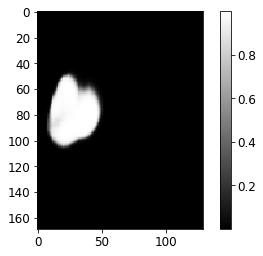

[iter: 421 ]: Training Loss: 0.02 	 Accuracy: 98.95
[iter: 422 ]: Training Loss: 0.02 	 Accuracy: 99.03
[iter: 423 ]: Training Loss: 0.02 	 Accuracy: 99.27
[iter: 424 ]: Training Loss: 0.03 	 Accuracy: 98.94
[iter: 425 ]: Training Loss: 0.03 	 Accuracy: 98.89
[iter: 426 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 427 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 428 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 429 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 430 ]: Training Loss: 0.03 	 Accuracy: 98.81
								 Testing Accuracy: 98.44
Plotting image of shape:  (169, 129)


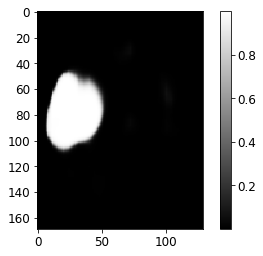

[iter: 431 ]: Training Loss: 0.02 	 Accuracy: 99.03
[iter: 432 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 433 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 434 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 435 ]: Training Loss: 0.02 	 Accuracy: 99.23
[iter: 436 ]: Training Loss: 0.02 	 Accuracy: 99.15
[iter: 437 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 438 ]: Training Loss: 0.02 	 Accuracy: 99.19
[iter: 439 ]: Training Loss: 0.02 	 Accuracy: 99.18
[iter: 440 ]: Training Loss: 0.02 	 Accuracy: 99.20
								 Testing Accuracy: 97.99
Plotting image of shape:  (169, 129)


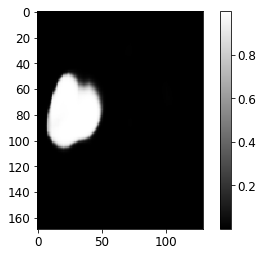

[iter: 441 ]: Training Loss: 0.02 	 Accuracy: 99.15
[iter: 442 ]: Training Loss: 0.02 	 Accuracy: 99.11
[iter: 443 ]: Training Loss: 0.02 	 Accuracy: 99.14
[iter: 444 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 445 ]: Training Loss: 0.02 	 Accuracy: 99.01
[iter: 446 ]: Training Loss: 0.02 	 Accuracy: 99.25
[iter: 447 ]: Training Loss: 0.02 	 Accuracy: 99.25
[iter: 448 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 449 ]: Training Loss: 0.02 	 Accuracy: 99.06
[iter: 450 ]: Training Loss: 0.03 	 Accuracy: 98.95
								 Testing Accuracy: 98.26
Plotting image of shape:  (169, 129)


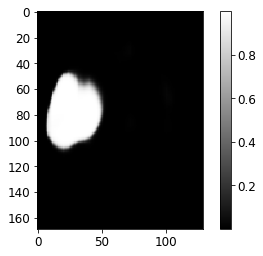

[iter: 451 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 452 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 453 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 454 ]: Training Loss: 0.02 	 Accuracy: 99.13
[iter: 455 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 456 ]: Training Loss: 0.02 	 Accuracy: 99.18
[iter: 457 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 458 ]: Training Loss: 0.02 	 Accuracy: 99.24
[iter: 459 ]: Training Loss: 0.02 	 Accuracy: 99.16
[iter: 460 ]: Training Loss: 0.02 	 Accuracy: 99.18
								 Testing Accuracy: 98.04
Plotting image of shape:  (169, 129)


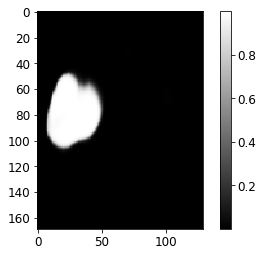

[iter: 461 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 462 ]: Training Loss: 0.02 	 Accuracy: 99.21
[iter: 463 ]: Training Loss: 0.02 	 Accuracy: 99.21
[iter: 464 ]: Training Loss: 0.02 	 Accuracy: 99.25
[iter: 465 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 466 ]: Training Loss: 0.02 	 Accuracy: 99.27
[iter: 467 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 468 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 469 ]: Training Loss: 0.02 	 Accuracy: 99.19
[iter: 470 ]: Training Loss: 0.02 	 Accuracy: 99.02
								 Testing Accuracy: 97.13
Plotting image of shape:  (169, 129)


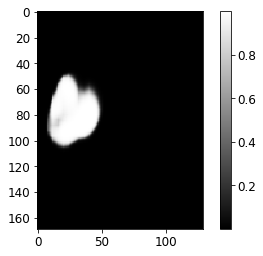

[iter: 471 ]: Training Loss: 0.04 	 Accuracy: 98.54
[iter: 472 ]: Training Loss: 0.03 	 Accuracy: 98.70
[iter: 473 ]: Training Loss: 0.02 	 Accuracy: 99.25
[iter: 474 ]: Training Loss: 0.02 	 Accuracy: 99.04
[iter: 475 ]: Training Loss: 0.03 	 Accuracy: 98.93
[iter: 476 ]: Training Loss: 0.02 	 Accuracy: 99.17
[iter: 477 ]: Training Loss: 0.02 	 Accuracy: 99.26
[iter: 478 ]: Training Loss: 0.02 	 Accuracy: 99.30
[iter: 479 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 480 ]: Training Loss: 0.02 	 Accuracy: 99.22
								 Testing Accuracy: 97.93
Plotting image of shape:  (169, 129)


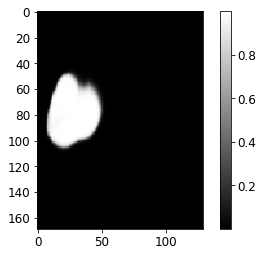

[iter: 481 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 482 ]: Training Loss: 0.02 	 Accuracy: 99.07
[iter: 483 ]: Training Loss: 0.02 	 Accuracy: 99.15
[iter: 484 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 485 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 486 ]: Training Loss: 0.03 	 Accuracy: 98.89
[iter: 487 ]: Training Loss: 0.03 	 Accuracy: 98.98
[iter: 488 ]: Training Loss: 0.02 	 Accuracy: 99.12
[iter: 489 ]: Training Loss: 0.02 	 Accuracy: 99.23
[iter: 490 ]: Training Loss: 0.02 	 Accuracy: 99.07
								 Testing Accuracy: 97.27
Plotting image of shape:  (169, 129)


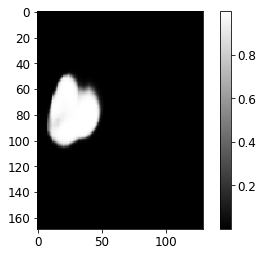

[iter: 491 ]: Training Loss: 0.02 	 Accuracy: 99.28
[iter: 492 ]: Training Loss: 0.02 	 Accuracy: 99.27
[iter: 493 ]: Training Loss: 0.03 	 Accuracy: 98.89
[iter: 494 ]: Training Loss: 0.03 	 Accuracy: 98.87
[iter: 495 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 496 ]: Training Loss: 0.02 	 Accuracy: 99.20
[iter: 497 ]: Training Loss: 0.02 	 Accuracy: 99.21
[iter: 498 ]: Training Loss: 0.02 	 Accuracy: 99.22
[iter: 499 ]: Training Loss: 0.02 	 Accuracy: 99.22
								 Testing Accuracy: 97.96
Plotting image of shape:  (169, 129)


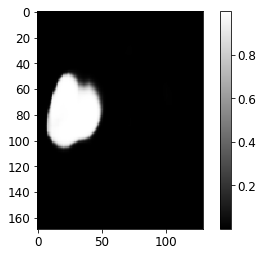

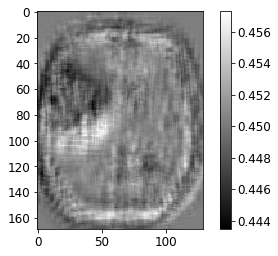

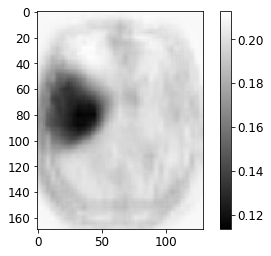

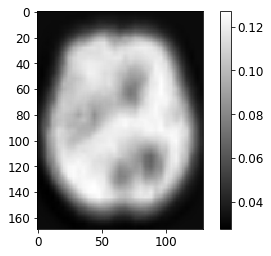

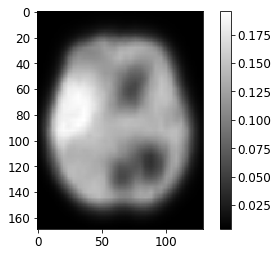

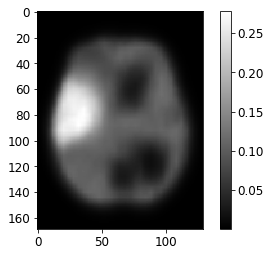

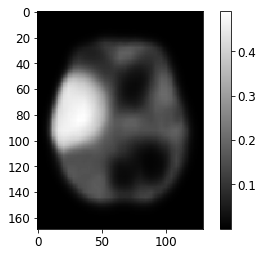

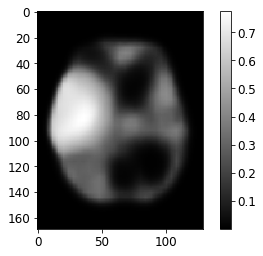

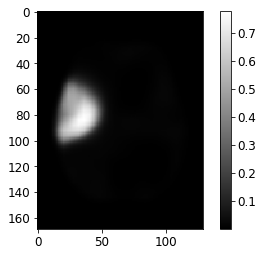

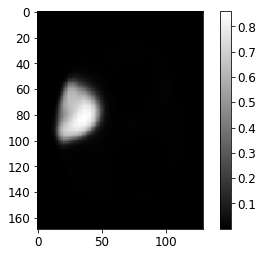

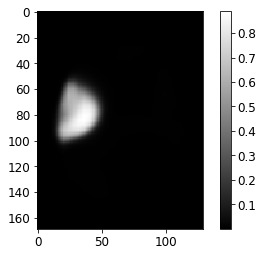

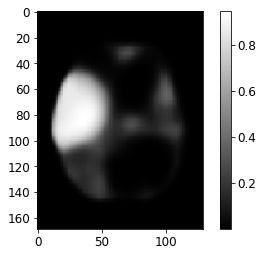

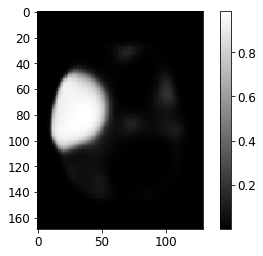

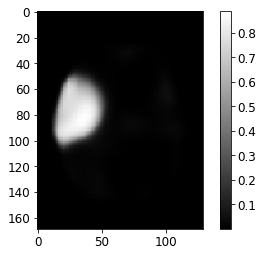

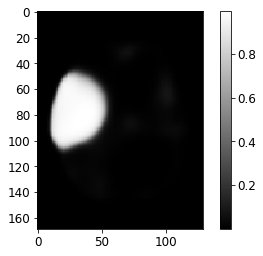

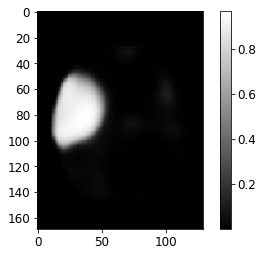

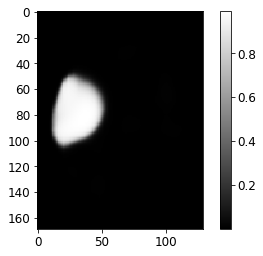

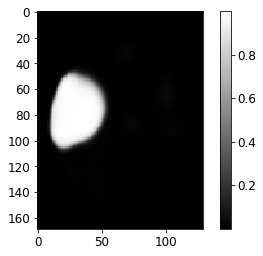

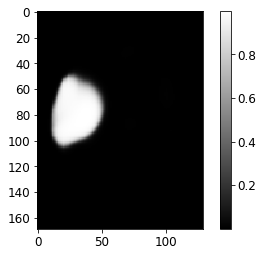

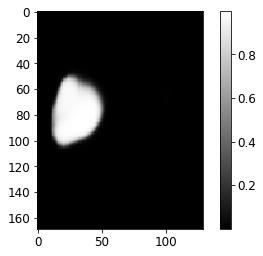

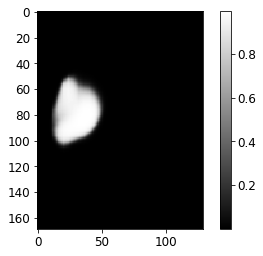

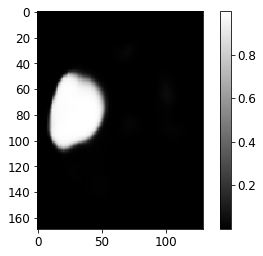

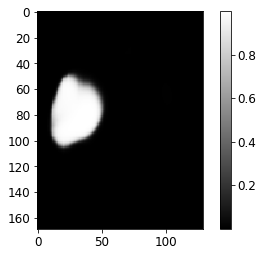

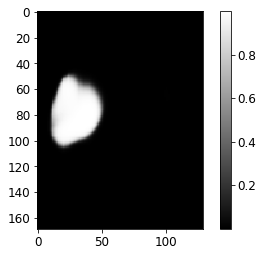

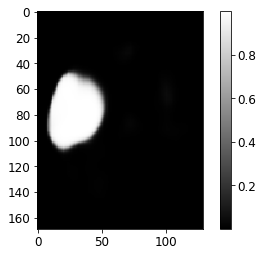

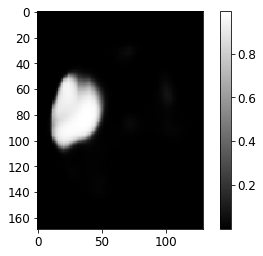

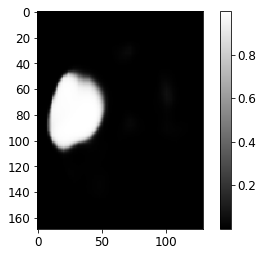

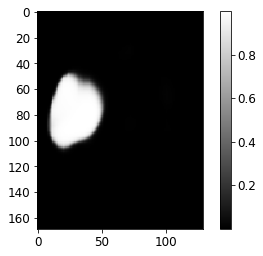

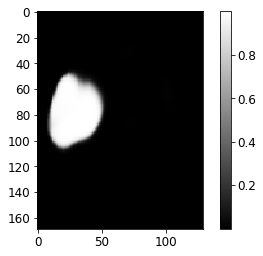

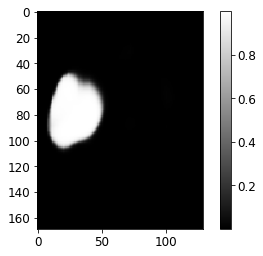

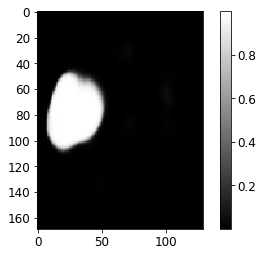

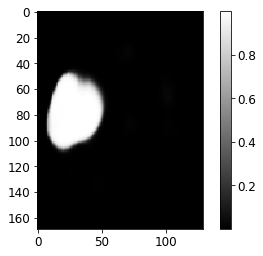

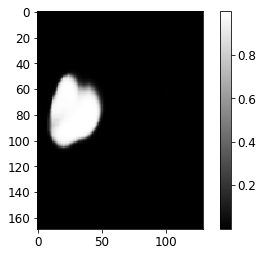

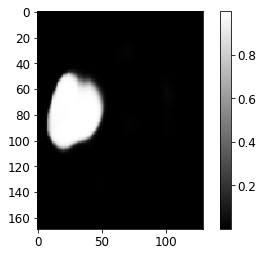

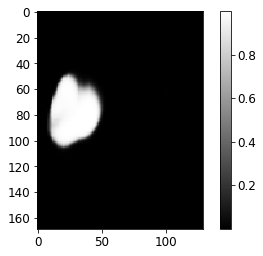

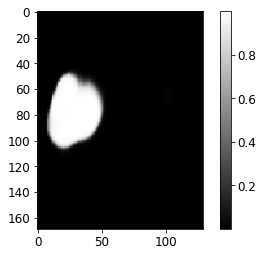

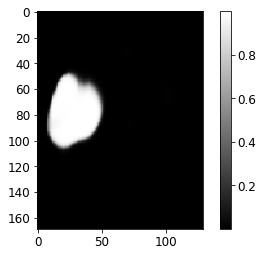

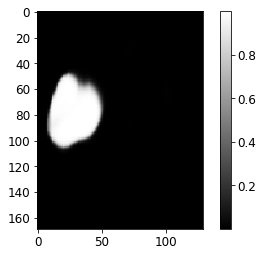

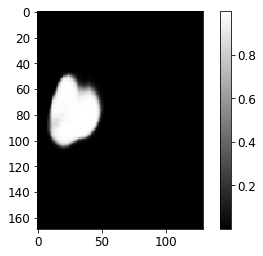

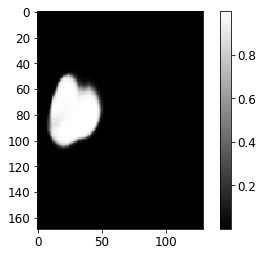

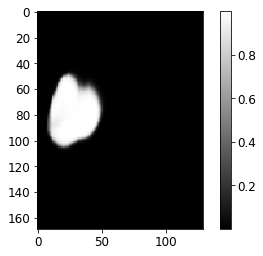

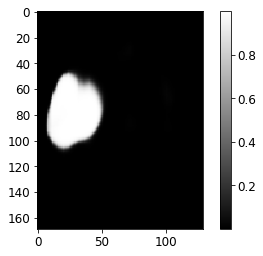

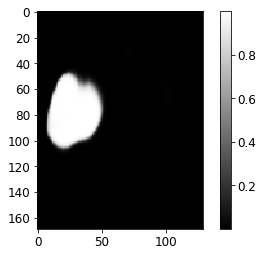

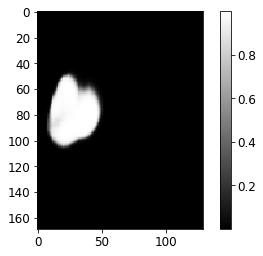

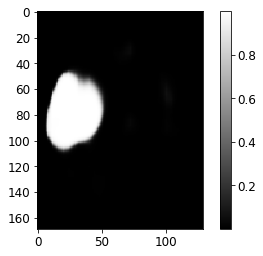

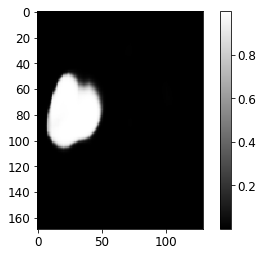

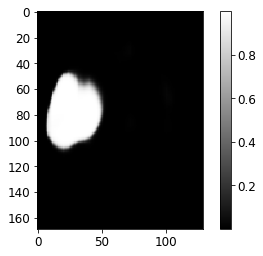

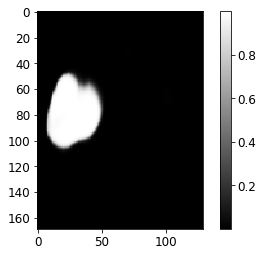

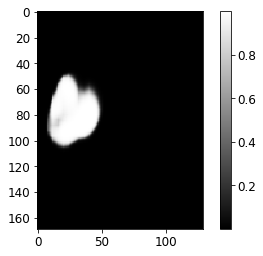

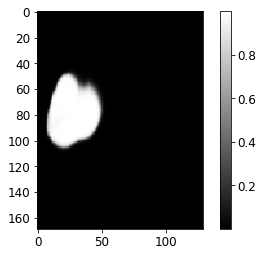

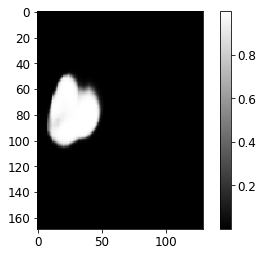

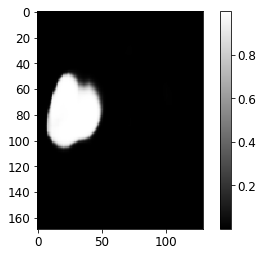

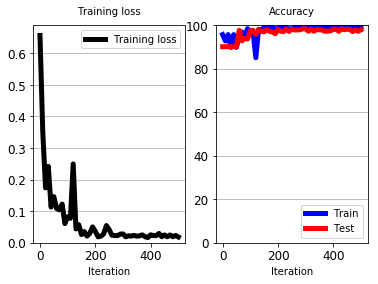

In [22]:
# For grayscale images, there is only 1 image channel. Add this channels dimension:
IMAGE_CHANNELS = 1
train_imgs_cnn = train_imgs.reshape([train_imgs.shape[0], IMAGE_CHANNELS, train_imgs.shape[1], train_imgs.shape[2]])
test_imgs_cnn = test_imgs.reshape([test_imgs.shape[0], IMAGE_CHANNELS, test_imgs.shape[1], test_imgs.shape[2]])

# Pad 31 voxels along each of the spatial dimensions of the input.
# So that the final output is of same size as original input.
# Preferably (roughly) half padding before, half after.
train_imgs_cnn = np.pad(train_imgs_cnn, ((0,0), (0,0), (15,16), (15,16)), mode='edge')
test_imgs_cnn = np.pad(test_imgs_cnn, ((0,0), (0,0), (15,16), (15,16)), mode='edge')
print("train_imgs_cnn.shape=", train_imgs_cnn.shape)
print("train_lbls.shape=", train_lbls.shape)

# Create the network
fclenet_seg = FCLeNet_Seg(num_classes=C_classes)

import torch.optim as optim
grad_descent_optimizer = optim.SGD(fclenet_seg.parameters(), lr=0.05, momentum=0.0)

# Start training
rng = np.random.RandomState(seed=SEED)
gradient_descent(fclenet_seg,
                 cross_entropy_segmentation,
                 grad_descent_optimizer,
                 rng,
                 train_imgs_cnn,
                 train_lbls_onehot,
                 test_imgs_cnn,
                 test_lbls_onehot,
                 N_batch_size=2, 
                 total_iters=500,
                 iters_per_test=10,
                 is_tumor_segm=True)

Copyright 2019, Imperial College London  